<a href="https://colab.research.google.com/github/Jeff-AB/ECE542FinalProject/blob/jeff-development/ECE542FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 542 Final Project

## Model Summary

<img src=https://ronjian.github.io/assets/Mask-RCNN/mask-rcnn.png width="500">

# References

# Mask R CNN
1. https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/

2. https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

3. https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46 (Best)

In [1]:
%tensorflow_version 1.x
import tensorflow
import os
import sys

# Google Colab or Local Notebook Settings
colab_notebook = True

data_dir = None
aug_data_dir = None

# Assign path variables
if colab_notebook:
    #Mount Google Drive Folder
    from google.colab import drive
    
    mount_dir = '/content/drive'
    drive.mount(mount_dir)
    
    data_dir = '/content/drive/My Drive/ECE 542 Final Project/cityscapes-data/leftImg8bit_trainvaltest/leftImg8bit'

    train_dir = '/content/drive/My Drive/ECE 542 Final Project/cityscapes-data/leftImg8bit_trainvaltest/leftImg8bit/train'
    val_dir = '/content/drive/My Drive/ECE 542 Final Project/cityscapes-data/leftImg8bit_trainvaltest/leftImg8bit/val'

    CITI_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapesScripts/')
    MASK_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')


    sys.path.append(MASK_ROOT)
    sys.path.append(CITI_ROOT)
    

TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os
import random

from tqdm import tqdm    
from mrcnn.utils import Dataset
from cityscapesscripts.helpers.csHelpers import getCoreImageFileName

class CityscapesSegmentationDataset(Dataset):
    
    def load_cityscapes(self, root_directory, subset):

        # add class names
        class_names = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']
        
        for i, name in enumerate(class_names[:-1]):
            self.add_class('cityscape', i, name)
        
        # license plate has id as -1
        #self.add_class('cityscape',-1,class_names[-1])


        if subset == 'train':
            self.data_dir = os.path.join(root_directory, 'train')
        elif subset == 'val':
            self.data_dir = os.path.join(root_directory, 'val')
        elif subset == 'test':
            self.data_dir = os.path.join(root_directory, 'test')
        else:
            raise Exception('No valid subset provided')
        
        # Create dictionary to house all files according to their image_id
        image_id_set = set()
        for root, dirs, filenames in os.walk(self.data_dir):
          for filename in filenames:
                image_id_set.add(getCoreImageFileName(filename))
        
        
        self._image_ids = list(image_id_set)
        print('---------------')
        print(self._image_ids)
        print('---------------')
        print(len(self._image_ids))
        # return self._image_ids
        
    def load_mask(self, image_id):
        '''
        Loads mask corresponding to an image id
        
        image_id: the unique id of the form city_sequenceNb_frame_Nb
        
        returns a bool array of masks and a list of class ids
        The polygons are extracted from the json files and constructed into a binary image
        using PIL. 
        '''
        
        city = image_id.split('_')[0] # First element in list should be city
        annotation_path = os.path.join(os.path.join(self.data_dir, city), image_id + '_gtFine_polygons.json')
        ann_dict = {}
        
        with open(annotation_path) as annotation:
            ann_dict = json.load(annotation)
        masks = []
        class_ids = []
        
        for obj in tqdm(ann_dict['objects']):
            class_ids.append(obj['label'])
            mask = Image.new(mode = '1', size = (ann_dict['imgWidth'], ann_dict['imgHeight']))
            draw = ImageDraw.Draw(mask)
            
            try:
                points = obj['polygon']
            except:
                print('no polygons for {}'.format(obj['label']))
            
            # PIL expects a tuple of tuples for points
            points = [tuple(coords) for coords in points]
            points = tuple(points)
            
            draw.polygon((points), fill=1)
            masks.append(mask)
        masks = np.stack(masks)
        return masks, class_ids

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')

print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapes-data/leftImg8bit_trainvaltest/leftImg8bit/train')

/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN


Using TensorFlow backend.


In [0]:
# csds = CityscapesSegmentationDataset()
# csds.load_cityscapes(data_dir, 'val')
# masks, class_ids = csds.load_mask('frankfurt_000000_000294')
# num_instances = len(class_ids)
# select = random.randint(0,num_instances - 1)

# print(class_ids[select])
# fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
# plt.imshow(np.asarray(masks[select]), cmap=plt.cm.gray)

In [0]:
from mrcnn.config import Config

GPU_COUNT = 1
IMAGES_PER_GPU = 1
LEARNING_RATE = 0.0001
NAME = 'cityscape'
NUM_CLASSES = 35 #1+34 # Background (inherited from utils.Dataset) + FG classes (listed below)
WEIGHT_DECAY = 0.0001

class TrainingConfig(Config):
    # TO-OPT: Set batch size to 20 by default.
    GPU_COUNT = GPU_COUNT
    IMAGES_PER_GPU = IMAGES_PER_GPU
    LEARNING_RATE = LEARNING_RATE
    NAME = NAME
    NUM_CLASSES = NUM_CLASSES
    WEIGHT_DECAY = WEIGHT_DECAY

config = TrainingConfig()
config.display()

class_names = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                47
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [0]:
#Training dataset.
dataset_train = CityscapesSegmentationDataset()
dataset_train.load_cityscapes(data_dir, 'train')
dataset_train.prepare()


# Validation dataset
dataset_val = CityscapesSegmentationDataset()
dataset_val.load_cityscapes(data_dir, 'val')
dataset_val.prepare()


---------------
['jena_000056_000019', 'strasbourg_000000_023694', 'dusseldorf_000059_000019', 'monchengladbach_000000_028563', 'bremen_000196_000019', 'strasbourg_000000_017283', 'cologne_000138_000019', 'cologne_000066_000019', 'dusseldorf_000185_000019', 'erfurt_000026_000019', 'weimar_000124_000019', 'stuttgart_000110_000019', 'bremen_000307_000019', 'tubingen_000056_000019', 'hamburg_000000_074425', 'ulm_000044_000019', 'stuttgart_000065_000019', 'hanover_000000_013205', 'aachen_000107_000019', 'darmstadt_000036_000019', 'darmstadt_000073_000019', 'bremen_000165_000019', 'bremen_000239_000019', 'zurich_000065_000019', 'cologne_000064_000019', 'bochum_000000_000885', 'cologne_000083_000019', 'bremen_000092_000019', 'weimar_000046_000019', 'bremen_000154_000019', 'stuttgart_000064_000019', 'zurich_000059_000019', 'weimar_000080_000019', 'cologne_000149_000019', 'cologne_000152_000019', 'hanover_000000_056457', 'bremen_000063_000019', 'bremen_000142_000019', 'aachen_000094_000019', '

In [0]:
dataset_train._image_ids

array([], dtype=int64)

In [0]:
# def load_cityscapes(root_directory, subset):
        # if subset == 'train':
        #     data_dir = os.path.join(root_directory, 'train')
        #     # print("here")
        # elif subset == 'val':
        #     data_dir = os.path.join(root_directory, 'val')
        # elif subset == 'test':
        #     data_dir = os.path.join(root_directory, 'test')
        # else:
        #     raise Exception('No valid subset provided')
        
        # # Create dictionary to house all files according to their image_id
        # image_id_set = set()
        # for root, dirs, filenames in tqdm(os.walk(data_dir)):
        #   for filename in filenames:
        #         image_id_set.add(getCoreImageFileName(filename))
        #         #print("in for")
        # image_ids = list(image_id_set)
        # print(len(image_ids))
        

In [0]:
print("Image IDs: {}".format(dataset_train._image_ids))
print("Image Count: {}".format(len(dataset_train._image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))

Image IDs: []
Image Count: 0
Class Count: 35


In [0]:
# Create model object in training mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO, excepting areas for training
# We can exclude the bounding box layers for now, but they will
# be useful for interpreting our images for now
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_bbox_fc",
                                                           "mrcnn_bbox",
                                                           "mrcnn_mask",
                                                           "mrcnn_class_logits"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
import keras
keras.__version__

'2.3.1'

In [0]:
model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/cityscape20200418T1936/mask_rcnn_cityscape_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5


UnboundLocalError: ignored

# Model Setup

Run this cell in order to setup the file structure that Mask R-CNN will expect to use. This includes MODEL_DIR for saving models, 

*   `MODEL_DIR`: directory to write trained models to
*   `COCO_MODEL_PATH`: directory to read trained models in from
*   `IMAGE_DIR`: directory root for image data (training and testing)


create config class based on application.

In [0]:
# Create model object in training mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO, excepting areas for training
# We can exclude the bounding box layers for now, but they will
# be useful for interpreting our images for now
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_bbox_fc",
                                                           "mrcnn_bbox",
                                                           "mrcnn_mask",
                                                           "mrcnn_class_logits"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead








# Dataset organization

TODO: We read in data using the following structure. This will allow us to have annotations stored in a JSON format in one directory with images stored in another with train and val subset labels respectively. 

```
DATA_DIR
│
└───annotations
│   │   bdd100k_labels_images_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```



# Model Training

Run these cells in order to train the Mask R-CNN model's mask and ROI-related layers (excludes CNN backbone layers). 

In [0]:
# Training dataset.
dataset_train = DeepDriveDataset()
dataset_train.load_deep_drive(data_dir + 'images/train/')
dataset_train.prepare()

# Validation dataset
dataset_val = DeepDriveDataset()
dataset_val.load_deep_drive(data_dir + 'images/val/')
dataset_val.prepare()

In [0]:
model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='heads',
            augmentation=None)  


Starting at epoch 0. LR=0.005

Checkpoint Path: /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200406T0544/mask_rcnn_bdd_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5


UnboundLocalError: ignored

AttributeError: ignored

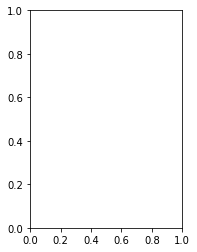

In [0]:
# Retrieve history for plotting loss and accuracy per epoch
history = model.keras_model.history.history

# Accuracy plot config
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Training and Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.grid()

# Loss plot config
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(('Training', 'Validation'))
plt.grid()

# Display plot
plt.show()

# Model Evaluation

Run these cells in order to receive an evaluation on a test image. First, the new model is selected from among the saved checkpoint models. Then, a configuration is set for inference (the same as before). Then a sample image is labeled using the Berkeley Deep Drive classes.

In [0]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200323T0458
No weight files in /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200323T2243
No weight files in /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200329T2328
No weight files in /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200406T0544


IndexError: ignored

In [0]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=config,
                          model_dir=ROOT_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: ignored

In [0]:
# Load a random image from the images folder
root, dirs, file_names = next(os.walk(IMAGE_DIR))
print(file_names)
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

['932c1c93-91f79869.jpg', '813ac0fa-296a3536.jpg', 'b090bc5d-1adf72c1.jpg', 'af29a474-3c32015c.jpg', 'b0409282-a0efc7da.jpg', 'a40f1068-fc077f35.jpg', '954b31d2-cc4c578a.jpg', '79fbe809-3c0a0517.jpg', 'a4bcd9f0-d150d9a2.jpg', '9f09c4ee-b09fd242.jpg', '7a4e7466-bb01f12a.jpg', '916e293b-0c92f2b7.jpg', '7eb06ba6-74b8ab7b.jpg', '899a1ac2-81e7aff1.jpg', '912e44a6-dc2d2079.jpg', '8a51b26a-9f6d5183.jpg', '8d9a9d66-1c5d5f51.jpg', '7e5568e2-d66c43ff.jpg', '851ec515-15faca1d.jpg', '89136a23-8d74f32f.jpg', '7c2747e6-2a97b7a9.jpg', '7a32fc03-c1010e49.jpg', 'a4adaa33-3c2c518a.jpg', '7ad2aa84-5a05b9be.jpg', 'ab8095e6-c9c6560e.jpg', '96fc04e6-4ca49b3e.jpg', '9e4c3aea-2d4d128f.jpg', '9c0b381f-55758a5e.jpg', '7d24a7cd-daeaf356.jpg', 'a51a039e-1dd6e515.jpg', '7c180959-333171a1.jpg', '9d2c870a-a0b6ac72.jpg', 'af265364-91fdf6d3.jpg', '8a5b5291-79dc07b6.jpg', 'a3b51b78-d5e379c3.jpg', 'a9712a33-bc93e05f.jpg', '8cb281a4-145328a9.jpg', '7c0a7d5a-bf5134a5.jpg', '7acb2160-00000000.jpg', '87e5b8c4-7abcf1c9.jpg',

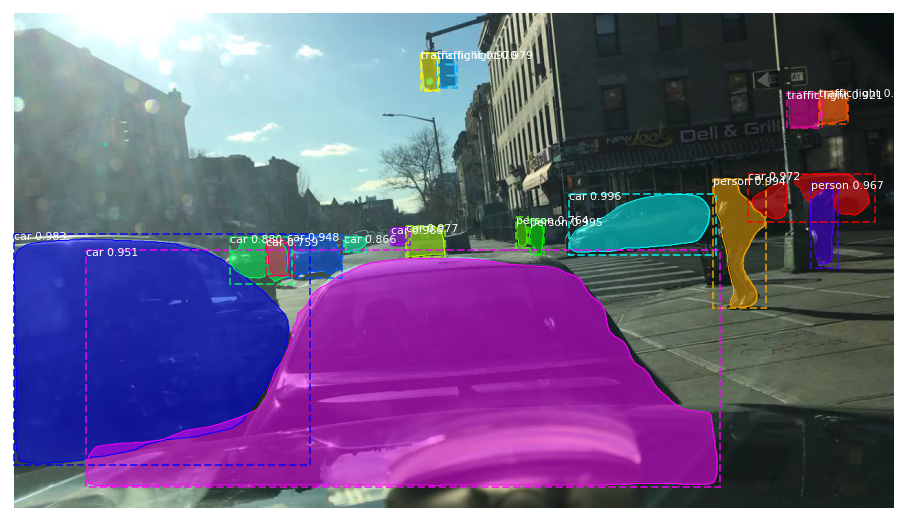

In [0]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])